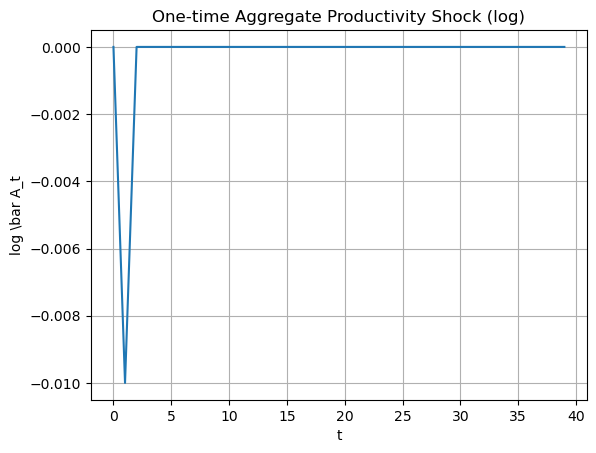

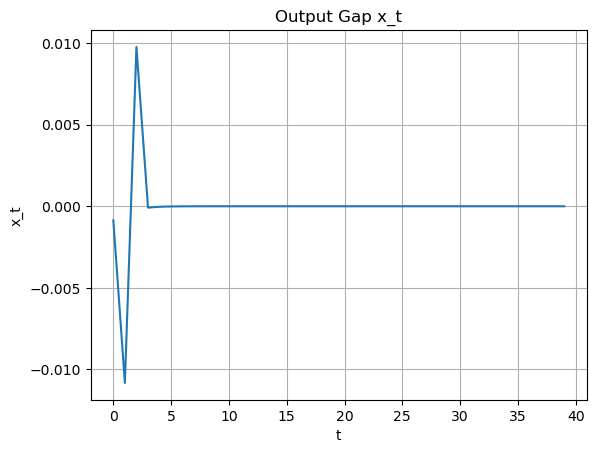

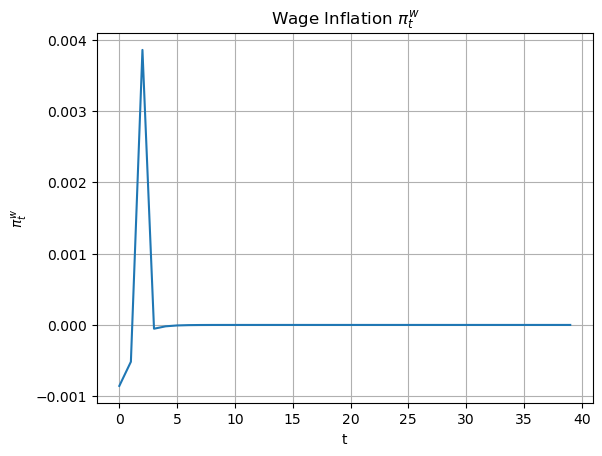

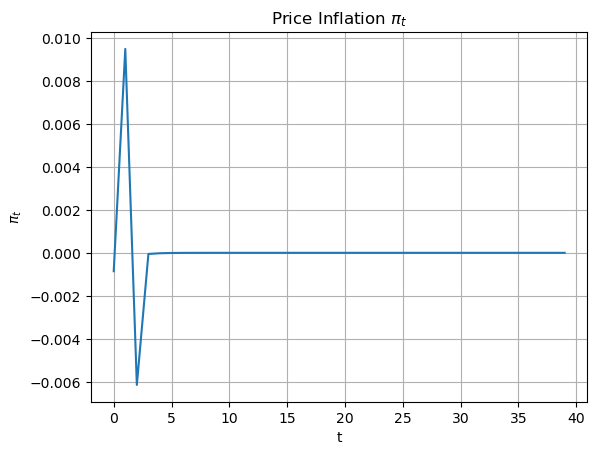

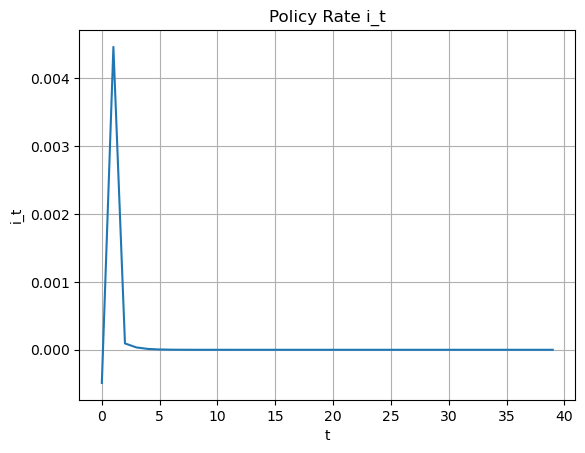

In [1]:
# Re-run after kernel reset

import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

beta   = 0.99
sigma  = 1.0
varphi = 1.0
epsw   = 11.0
phiw   = 50.0
phi_pi = 1.8
phi_x  = 0.1
rho_i  = 0.7

kappaw = (epsw - 1.0)/phiw
c1 = sigma*(1.0+varphi)/(sigma+varphi)

T   = 40
t0  = 1
dA  = -0.01
abar = np.zeros(T)
abar[t0] = dA

def solve_macro(abar_path):
    T = len(abar_path)
    z0 = np.zeros(4*T)
    def residuals(z):
        x   = z[0::4]; pi  = z[1::4]; piw = z[2::4]; ii  = z[3::4]
        abar = abar_path
        abar_lag = np.zeros(T); abar_lag[0] = 0.0; abar_lag[1:] = abar[:-1]
        i_lag = np.zeros(T); i_lag[0] = 0.0; i_lag[1:] = ii[:-1]
        x_next = np.zeros(T); x_next[:-1] = x[1:]
        pi_next = np.zeros(T); pi_next[:-1] = pi[1:]
        piw_next = np.zeros(T); piw_next[:-1] = piw[1:]
        res = np.zeros(4*T)
        for t in range(T):
            res[4*t + 0] = x[t] - ( x_next[t] - (1.0/sigma)*( ii[t] - pi_next[t] - c1*(abar[t]-abar_lag[t]) ) )
            res[4*t + 2] = piw[t] - ( beta*piw_next[t] + kappaw*(sigma+varphi)*x[t] )
            res[4*t + 1] = pi[t] - ( piw[t] - (abar[t] - abar_lag[t]) )
            res[4*t + 3] = ii[t] - ( rho_i*i_lag[t] + (1.0-rho_i)*( phi_pi*pi[t] + phi_x*x[t] ) )
        return res
    sol = root(residuals, z0, method='hybr', tol=1e-12, options={'maxfev': 100000})
    return sol

sol = solve_macro(abar)
assert sol.success, sol.message

z = sol.x
x   = z[0::4]; pi  = z[1::4]; piw = z[2::4]; ii  = z[3::4]
h = np.arange(T)

plt.figure(); plt.plot(h, abar); plt.title('One-time Aggregate Productivity Shock (log)'); plt.xlabel('t'); plt.ylabel('log \\bar A_t'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, x); plt.title('Output Gap x_t'); plt.xlabel('t'); plt.ylabel('x_t'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, piw); plt.title('Wage Inflation $\\pi_t^w$'); plt.xlabel('t'); plt.ylabel('$\\pi_t^w$'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, pi); plt.title('Price Inflation $\\pi_t$'); plt.xlabel('t'); plt.ylabel('$\\pi_t$'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, ii); plt.title('Policy Rate i_t'); plt.xlabel('t'); plt.ylabel('i_t'); plt.grid(True); plt.show()


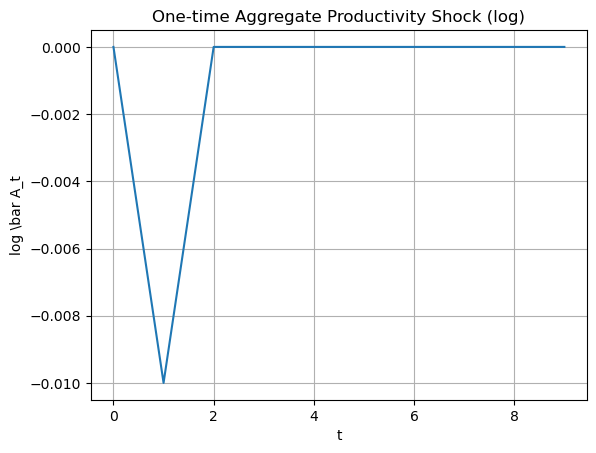

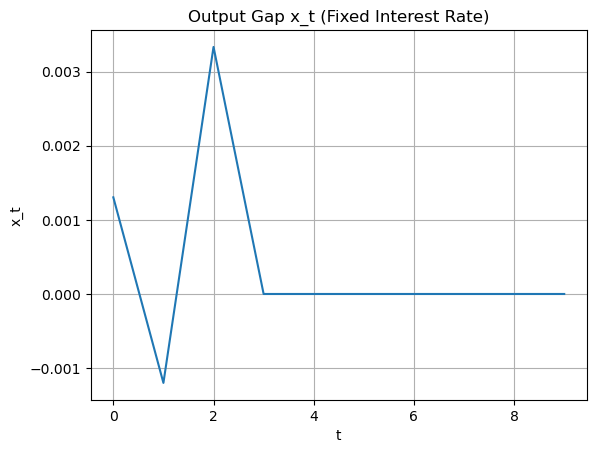

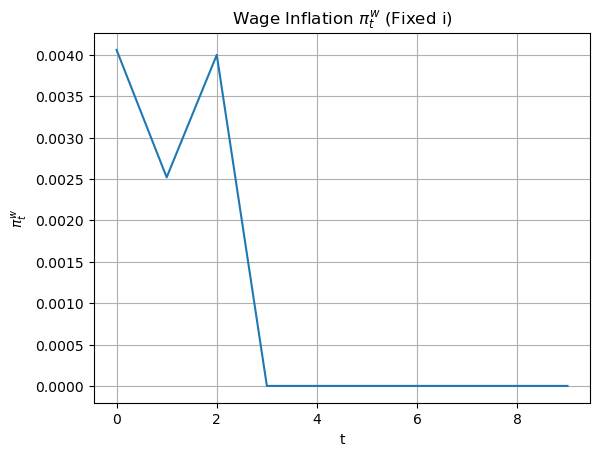

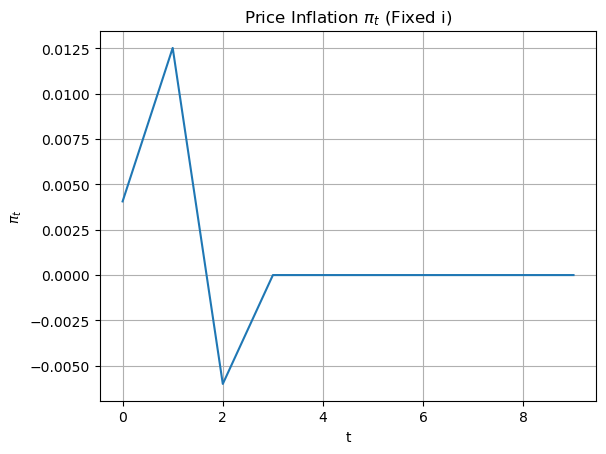

In [5]:
# Sticky-wage NK with a FIXED nominal interest rate (perfect foresight)
# We keep the same one-time aggregate productivity shock as before.
# Solves for (x, pi, piw) given an exogenous i_t path (here constant).

import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

# -------------------------
# 1) Parameters
# -------------------------
beta = 0.99
sigma  = 5.0
varphi = 1.0
epsw   = 11.0
phiw   = 50.0

kappaw = (epsw - 1.0)/phiw
c1 = sigma*(1.0+varphi)/(sigma+varphi)   # r^n = c1 * Δ\bar a

# -------------------------
# 2) Shock path: one-time jump in \bar a_t at t0
# -------------------------
T   = 10
t0  = 1
dA  = -0.01
abar = np.zeros(T)
abar[t0] = dA

# -------------------------
# 3) Fixed interest rate path (e.g., ZLB or peg): i_t = i_bar for all t
# -------------------------
i_bar = 0.0
i_path = np.full(T, i_bar)

# -------------------------
# 4) Perfect-foresight macro solver with fixed i_t
# -------------------------
def solve_macro_fixed_i(abar_path, i_path):
    T = len(abar_path)
    assert len(i_path) == T
    z0 = np.zeros(3*T)  # [x, pi, piw] stacked
    
    def residuals(z):
        x   = z[0::3]
        pi  = z[1::3]
        piw = z[2::3]
        ii  = i_path
        
        abar = abar_path
        abar_lag = np.zeros(T); abar_lag[0] = 0.0; abar_lag[1:] = abar[:-1]
        
        # Perfect-foresight expectations: next period actuals, terminal set to 0
        x_next = np.zeros(T);   x_next[:-1]  = x[1:]
        pi_next = np.zeros(T);  pi_next[:-1] = pi[1:]
        piw_next = np.zeros(T); piw_next[:-1]= piw[1:]
        
        res = np.zeros(3*T)
        for t in range(T):
            # IS with fixed i_t
            res[3*t + 0] = x[t] - ( x_next[t] - (1.0/sigma)*( ii[t] - pi_next[t] - c1*(abar[t]-abar_lag[t]) ) )
            # Wage NKPC
            res[3*t + 2] = piw[t] - ( beta*piw_next[t] + kappaw*(sigma+varphi)*x[t] )
            # Price identity
            res[3*t + 1] = pi[t] - ( piw[t] - (abar[t] - abar_lag[t]) )
        return res
    
    sol = root(residuals, z0, method='hybr', tol=1e-12, options={'maxfev': 100000})
    return sol

sol = solve_macro_fixed_i(abar, i_path)
assert sol.success, sol.message

z = sol.x
x   = z[0::3]
pi  = z[1::3]
piw = z[2::3]
h = np.arange(T)

# -------------------------
# 5) Plots
# -------------------------
plt.figure(); plt.plot(h, abar); plt.title('One-time Aggregate Productivity Shock (log)'); plt.xlabel('t'); plt.ylabel('log \\bar A_t'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, x); plt.title('Output Gap x_t (Fixed Interest Rate)'); plt.xlabel('t'); plt.ylabel('x_t'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, piw); plt.title('Wage Inflation $\\pi_t^w$ (Fixed i)'); plt.xlabel('t'); plt.ylabel('$\\pi_t^w$'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, pi); plt.title('Price Inflation $\\pi_t$ (Fixed i)'); plt.xlabel('t'); plt.ylabel('$\\pi_t$'); plt.grid(True); plt.show()


In [11]:
import numpy as np
import math as mp
import pandas as pd

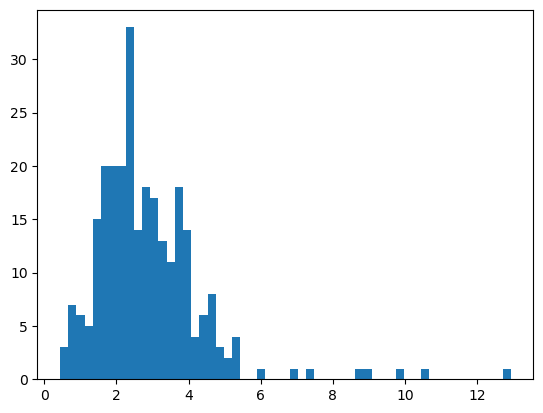

In [12]:
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
import matplotlib.pyplot as plt
plt.hist(data_tau,bins = 55)
plt.show()

In [13]:
sigma = 5
beta = 1 /( 1.0 +0.01)
beta1 =1/( (1.0 +0.01* np.exp(30/(36.5*0.9)))) 
W = 1

In [14]:
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_10624/1678760125.py:4: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_10624/1678760125.py:5: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_10624/1678760125.py:7: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


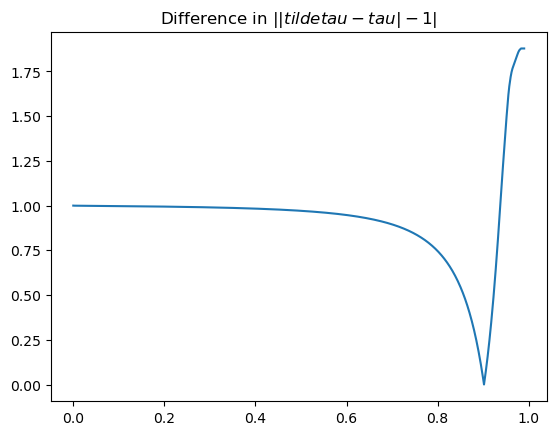

In [15]:
plt.plot(np.linspace(0, 0.99, 1000),np.abs(tau_diff-1))
plt.title('Difference in $||tildetau - tau| -1|$')

plt.show()

In [16]:
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]

In [17]:
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]

In [23]:
N=-data_tau - 1/np.log(beta*c) 
tau= -1/np.log(beta*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta*c)**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  
tprod = (beta*c)**tau * (tau + N)

In [24]:
tau = np.array(tau, dtype=int)

In [25]:

def generate_pattern_array_with_extra_rows(tau):
    # 1) Create the original n×n pattern
    n = len(tau)+ int(np.min(tau))
    m = int(np.max(tau)) + int(np.min(tau))

    mx = int(max(tau))
    missing_count = len(set(range(int(max(tau) )+ 1)) - set(tau))


    A = np.ones((m+2, n+missing_count), dtype=float)
    count = 0
    for i in range(1, m+2):
        for j in range(len(tau[tau == i-1])):
            A[i, n- i-j - count] = 0.99  # 0.9 shifts diagonally from right to left as we go down
        if len(tau[tau == i-1]) > 1:
            count += len(tau[tau == i-1])-1
    # 2) Create the two extra rows:
    #    (a) one row with 0.9 at the leftmost column,
    #    (b) one row of all ones.

    row_all_ones = np.ones(n+missing_count, dtype=float)
    A_extended = np.vstack([A,row_all_ones])
    A_extended = A_extended[:,0:n - int(np.min(tau))]

    return A_extended

In [30]:
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0  
    tau1_floor = np.floor(tau1)
    tau1_ceil = np.ceil(tau1)
    tprod1_ceil=  (beta*c)**tau1_ceil * (tau1_ceil + N)
    tprod1_floor=  (beta*c)**tau1_floor * (tau1_floor + N)

    tau1[(tprod1_ceil-tprod1_floor)>0] = tau1_ceil[(tprod1_ceil-tprod1_floor)>0]
    tau1[(tprod1_ceil-tprod1_floor)<0] = tau1_floor[(tprod1_ceil-tprod1_floor)<0]
    tau1[tau1<0] = 0  
    tprod1 = (beta*c)**tau1 * (tau1 + N)


    tau1 = tau1[::-1]

    tprod1=  np.array((beta*c)**tau1 * (tau1 + N) )  

In [ ]:
A= generate_pattern_array_with_extra_rows(tau1)


In [38]:
A_prod = np.sum( (A*tprod1)**(sigma-1),axis = 1)**(1/(sigma-1))

In [44]:
(A_prod - A_prod[0])/A_prod[0]

array([ 0.00000000e+00, -2.63839543e-05, -1.09905185e-03, -2.82192601e-03,
       -2.60963796e-03, -1.88884924e-03, -1.01243950e-03, -6.33501339e-05,
       -6.29816989e-05,  0.00000000e+00, -1.54496296e-04, -7.41028219e-05,
       -4.87167668e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

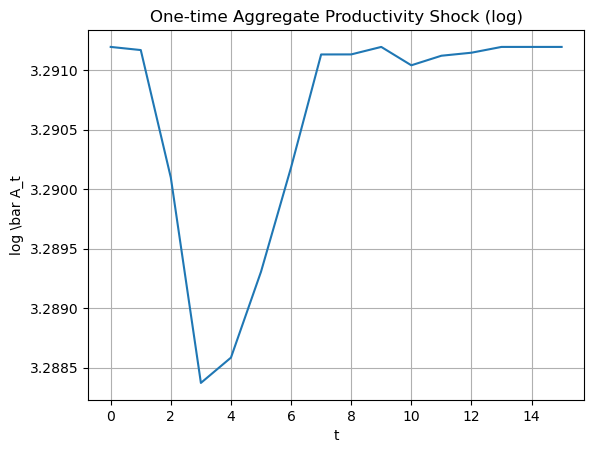

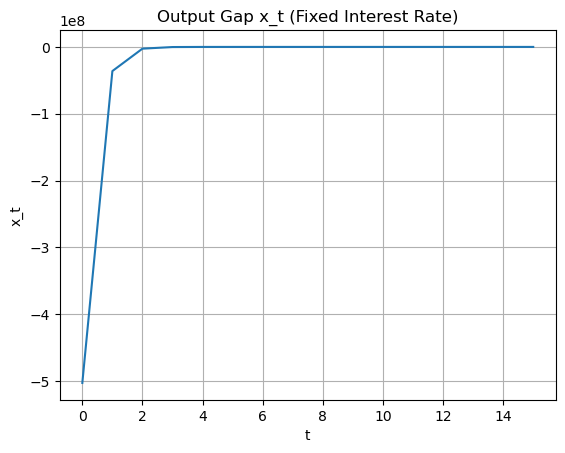

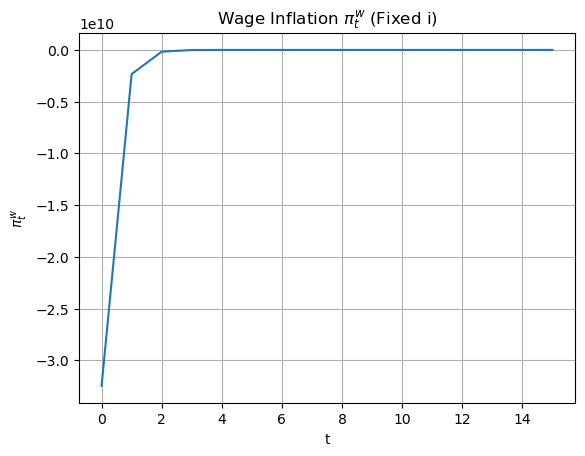

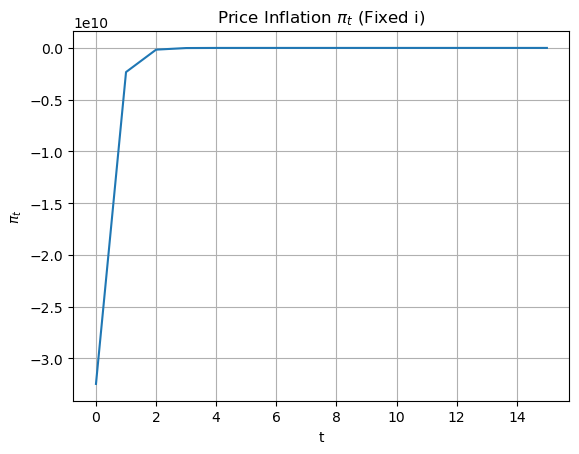

In [55]:
# Sticky-wage NK with a FIXED nominal interest rate (perfect foresight)
# We keep the same one-time aggregate productivity shock as before.
# Solves for (x, pi, piw) given an exogenous i_t path (here constant).

import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

# -------------------------
# 1) Parameters
# -------------------------
beta = 0.99
sigma  = 5.0
varphi = 1.0
epsw   = 11.0
phiw   = 1

kappaw = (epsw - 1.0)/phiw
c1 = 0  # r^n = c1 * Δ\bar a

# -------------------------
# 2) Shock path: one-time jump in \bar a_t at t0
# -------------------------
T   = 16
abar = np.log(A_prod)

# -------------------------
# 3) Fixed interest rate path (e.g., ZLB or peg): i_t = i_bar for all t
# -------------------------
i_bar = 0.0
i_path = np.full(T, i_bar)

# -------------------------
# 4) Perfect-foresight macro solver with fixed i_t
# -------------------------
def solve_macro_fixed_i(abar_path, i_path):
    T = len(abar_path)
    assert len(i_path) == T
    z0 = np.zeros(3*T)  # [x, pi, piw] stacked
    
    def residuals(z):
        x   = z[0::3]
        pi  = z[1::3]
        piw = z[2::3]
        ii  = i_path
        
        abar = abar_path
        abar_lag = np.zeros(T); abar_lag[0] = 3.29119651; abar_lag[1:] = abar[:-1]
        
        # Perfect-foresight expectations: next period actuals, terminal set to 0
        x_next = np.zeros(T);   x_next[:-1]  = x[1:]
        pi_next = np.zeros(T);  pi_next[:-1] = pi[1:]
        piw_next = np.zeros(T); piw_next[:-1]= piw[1:]
        
        res = np.zeros(3*T)
        for t in range(T):
            # IS with fixed i_t
            res[3*t + 0] = x[t] - ( x_next[t] - (1.0/sigma)*( ii[t] - pi_next[t] - c1*(abar[t]-abar_lag[t]) ) )
            # Wage NKPC
            res[3*t + 2] = piw[t] - ( beta*piw_next[t] + kappaw*(sigma+varphi)*x[t] )
            # Price identity
            res[3*t + 1] = pi[t] - ( piw[t] - (abar[t] - abar_lag[t]) )
        return res
    
    sol = root(residuals, z0, method='hybr', tol=1e-12, options={'maxfev': 100000})
    return sol

sol = solve_macro_fixed_i(abar, i_path)
assert sol.success, sol.message

z = sol.x
x   = z[0::3]
pi  = z[1::3]
piw = z[2::3]
h = np.arange(T)

# -------------------------
# 5) Plots
# -------------------------
plt.figure(); plt.plot(h, abar); plt.title('One-time Aggregate Productivity Shock (log)'); plt.xlabel('t'); plt.ylabel('log \\bar A_t'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, x); plt.title('Output Gap x_t (Fixed Interest Rate)'); plt.xlabel('t'); plt.ylabel('x_t'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, piw); plt.title('Wage Inflation $\\pi_t^w$ (Fixed i)'); plt.xlabel('t'); plt.ylabel('$\\pi_t^w$'); plt.grid(True); plt.show()
plt.figure(); plt.plot(h, pi); plt.title('Price Inflation $\\pi_t$ (Fixed i)'); plt.xlabel('t'); plt.ylabel('$\\pi_t$'); plt.grid(True); plt.show()

In [54]:
np.log(A_prod)

array([3.29119651, 3.29117013, 3.29009686, 3.2883706 , 3.28858346,
       3.28930588, 3.29018356, 3.29113316, 3.29113353, 3.29119651,
       3.291042  , 3.29112241, 3.29114779, 3.29119651, 3.29119651,
       3.29119651])